In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import xgboost as xgb


warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


In [3]:
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
print(df.shape[1])
print(df.shape[0])

21
7043


In [6]:
# Veri tiplerini göster
print(df.dtypes)

# Eksik veri var mı kontrolü
print(df.isnull().sum())

# TotalCharges sütunundaki boşlukları kontrol et (genelde sayısal ama string olabilir)
print(df['TotalCharges'].unique()[:10])  # Örnek birkaç değer gösterelim


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
Mo

In [7]:
# TotalCharges sütununu sayıya çevir, hata olanları NaN yap
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

print(df['TotalCharges'].isnull().sum())

print(df[df['TotalCharges'].isnull()])

11
      customerID  gender  SeniorCitizen Partner Dependents  tenure  \
488   4472-LVYGI  Female              0     Yes        Yes       0   
753   3115-CZMZD    Male              0      No        Yes       0   
936   5709-LVOEQ  Female              0     Yes        Yes       0   
1082  4367-NUYAO    Male              0     Yes        Yes       0   
1340  1371-DWPAZ  Female              0     Yes        Yes       0   
3331  7644-OMVMY    Male              0     Yes        Yes       0   
3826  3213-VVOLG    Male              0     Yes        Yes       0   
4380  2520-SGTTA  Female              0     Yes        Yes       0   
5218  2923-ARZLG    Male              0     Yes        Yes       0   
6670  4075-WKNIU  Female              0     Yes        Yes       0   
6754  2775-SEFEE    Male              0      No        Yes       0   

     PhoneService     MultipleLines InternetService       OnlineSecurity  ...  \
488            No  No phone service             DSL                  Yes  .

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [8]:
df = df[df['TotalCharges'].notnull()]
print(df.shape)

(7032, 21)


In [9]:
df = df.drop('customerID', axis=1)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

print(df.isnull().sum())
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('Churn')

df = pd.get_dummies(df, columns=categorical_cols)

df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [10]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Doğruluk:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Doğruluk: 0.8009950248756219
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1033
           1       0.64      0.58      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



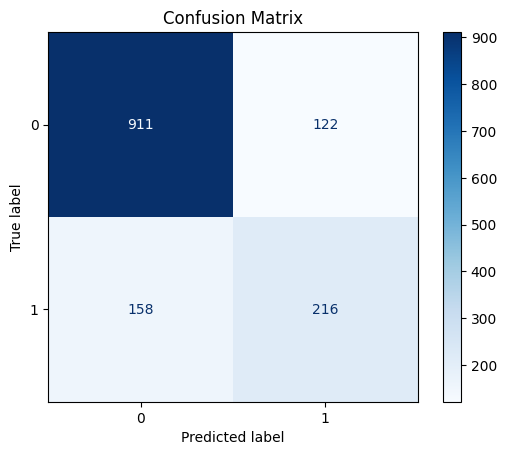

In [12]:
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

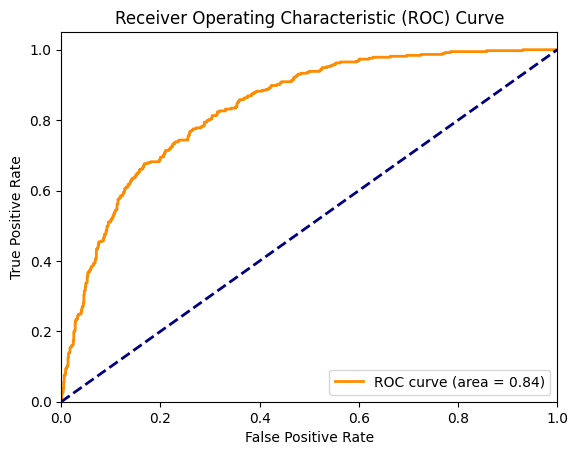

In [13]:
y_probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [14]:
model = LogisticRegression(max_iter=1000)
param_grid = {
    'C': [0.01, 0.1, 1],
    'solver': ['liblinear', 'lbfgs']
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("En iyi parametreler:", grid_search.best_params_)
print("En iyi doğruluk:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

En iyi parametreler: {'C': 0.01, 'solver': 'lbfgs'}
En iyi doğruluk: 0.8067555555555556


In [15]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Doğruluk:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Doğruluk: 0.7903340440653873
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407



In [16]:
from sklearn.svm import SVC

svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("SVM Doğruluk:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM Doğruluk: 0.7341862117981521
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1033
           1       0.00      0.00      0.00       374

    accuracy                           0.73      1407
   macro avg       0.37      0.50      0.42      1407
weighted avg       0.54      0.73      0.62      1407



In [17]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Doğruluk:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Doğruluk: 0.7683013503909026
              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1033
           1       0.57      0.52      0.54       374

    accuracy                           0.77      1407
   macro avg       0.70      0.69      0.69      1407
weighted avg       0.76      0.77      0.76      1407



In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
models = {
    "Logistic Regression": best_model,
    "Random Forest": rf_model,
    "SVM": svm_model,
    "XGBoost": xgb_model
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    # ROC için probabilistik tahmin (bazı modellerde bu yoksa alternatif kullanılır)
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test)[:, 1]
    else:
        y_probs = model.decision_function(X_test)  # SVM için
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_probs)
    })

# DataFrame oluştur
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="F1-Score", ascending=False))


                 Model  Accuracy  Precision    Recall  F1-Score   ROC AUC
0  Logistic Regression  0.801706   0.655738  0.534759  0.589102  0.836726
1        Random Forest  0.790334   0.637631  0.489305  0.553707  0.814474
3              XGBoost  0.768301   0.571006  0.516043  0.542135  0.813951
2                  SVM  0.734186   0.000000  0.000000  0.000000  0.789962


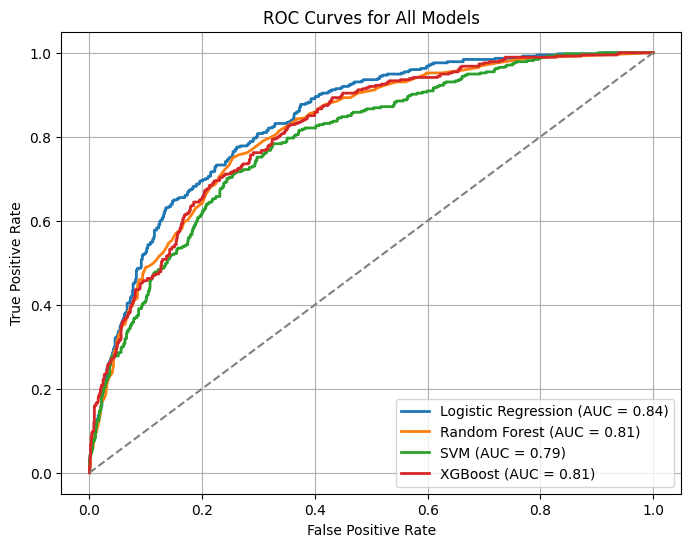

In [19]:
plt.figure(figsize=(8, 6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test)[:, 1]
    else:
        y_probs = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

# Rastgele model çizgisi
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend(loc="lower right")
plt.grid()
plt.show()
